### Desperately Seeking Silver

We are going to focus on the 2012 Presidential election.

We are going to focus on the 2012 Presidential election. Analysts like Nate Silver, Drew Linzer, and Sam Wang developed highly accurate models that correctly forecasted most or all of the election outcomes in each of the 50 states. We will explore how hard it is to recreate similarly successful models.

Outcomes:

1. To practice data manipulation with Pandas
2. To develop intuition about the interplay of **precision**, **accuracy**, and **bias** when making predictions
3. To better understand how election forecasts are constructed


In [52]:
"""   
helper python script that contains all functions 
referenced in this ipynb.
"""
%run hw2.py

<Figure size 1500x900 with 0 Axes>

In [2]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
%precision 2

'%.2f'

In [3]:
from matplotlib.rcsetup import cycler

mpl.rc('figure', figsize=(10,6), dpi=150)
mpl.rc('axes', facecolor='white', 
       prop_cycle=cycler('color', dark2_colors ))
mpl.rc('lines', lw=2)
mpl.rc('patch', ec='white', fc=dark2_colors[0])
mpl.rc('font', size=14, family='StixGeneral')

In [4]:
# We are pretending to build our model 1 month before the election
import datetime
today = datetime.datetime(2012, 10, 2)
today

datetime.datetime(2012, 10, 2, 0, 0)

In [10]:
# loading all previously used datasets
electoral_votes = pd.read_csv("../data/hw2_data/electoral_votes.csv").set_index('State')
predictwise = pd.read_csv('../data/hw2_data/predictwise.csv').set_index('States')
gallup_2012=pd.read_csv("../data/hw2_data/g12.csv").set_index('State')
gallup_08 = pd.read_csv("../data/hw2_data/g08.csv").set_index('State')
results_08 = pd.read_csv('../data/hw2_data/2008results.csv').set_index('State')

In [5]:
electoral_votes.head()

,Votes
State,
California,55
Texas,38
New York,29
Florida,29
Illinois,20


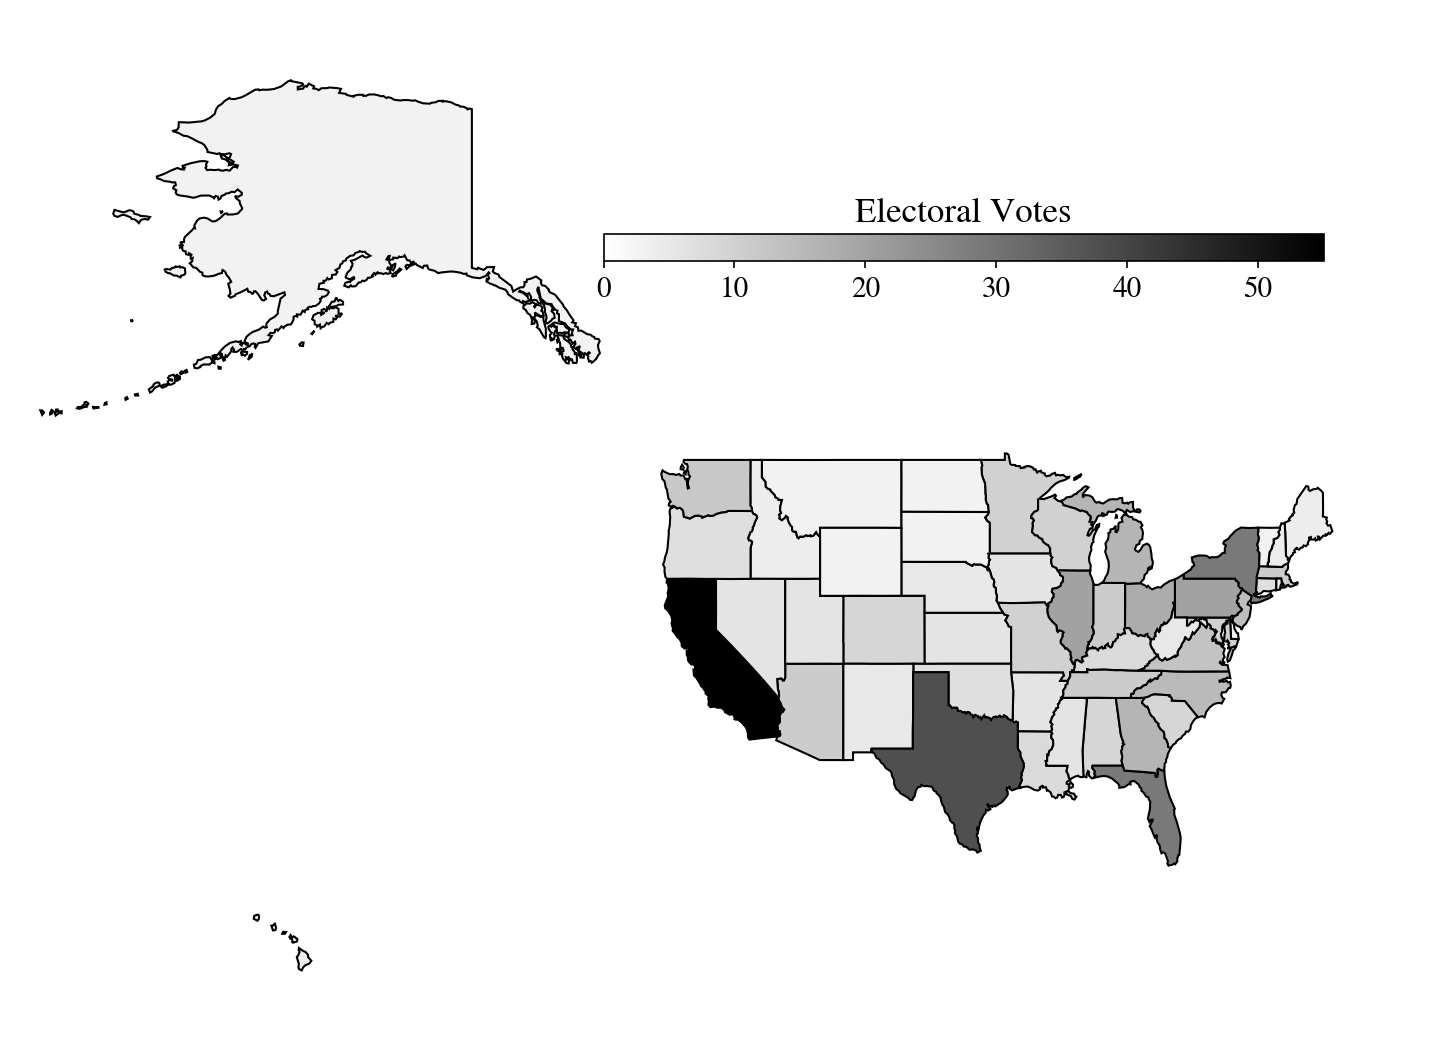

In [6]:
make_map(electoral_votes.Votes, "Electoral Votes")

### Question 1: Simulating elections

Our reference point:
[PredictWise](http://www.predictwise.com/results/2012/president)'s quite successful forecast, released on October 2, 2012.

PredictWise aggregated polling data and, for each state, estimated the probability that the Obama or Romney would win. Here are those estimated probabilities:


In [6]:
predictwise.head()

,Obama,Romney,Votes
States,,,
Alabama,0.000,1.000,9
Alaska,0.000,1.000,3
Arizona,0.062,0.938,11
Arkansas,0.000,1.000,6
California,1.000,0.000,55


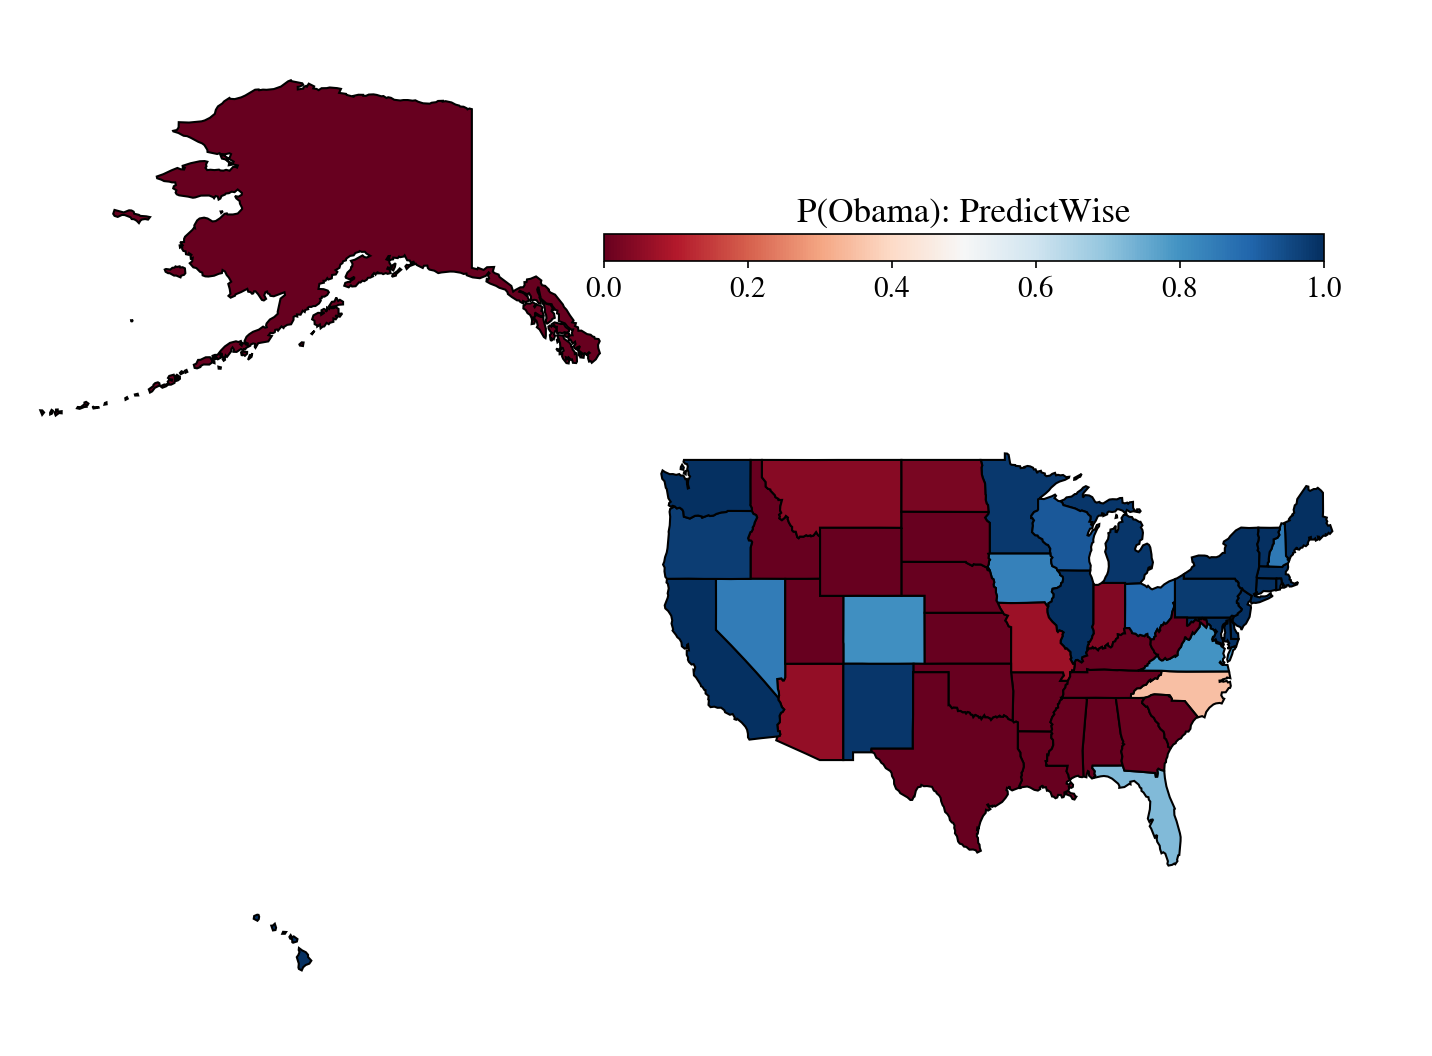

In [8]:
# Using make_map, plot the probability that
# Obama wins each state, according to this prediction.
make_map(predictwise.Obama, "P(Obama): PredictWise")

Even when we assume the win probabilities in each state are known, there is still uncertainty left in the election. We will use simulations from a simple probabilistic model to characterize this uncertainty.

We will assume that the outcome in each state is the result of an independent coin flip whose probability of coming up Obama is given by a Dataframe of state-wise win probabilities.

From these simulations, we will be able to make a prediction about the expected outcome of the election

In [10]:
predictwise.Obama.values.reshape(-1,1)[:5]

array([[0.   ],
       [0.   ],
       [0.062],
       [0.   ],
       [1.   ]])

The following cells takes the necessary DataFrame for the Predictwise data, and runs 10000 simulations. 

We use the results to compute the probability, according to this predictive model, that Obama **wins** the election (i.e., the probability that he receives `269 or more` electoral college votes)

In [14]:
result = simulate_election(predictwise, 10000)
result

array([309, 332, 337, ..., 322, 338, 326])

In [16]:
#compute the probability of an Obama win, given this simulation
print((result >= 269).mean())

0.996


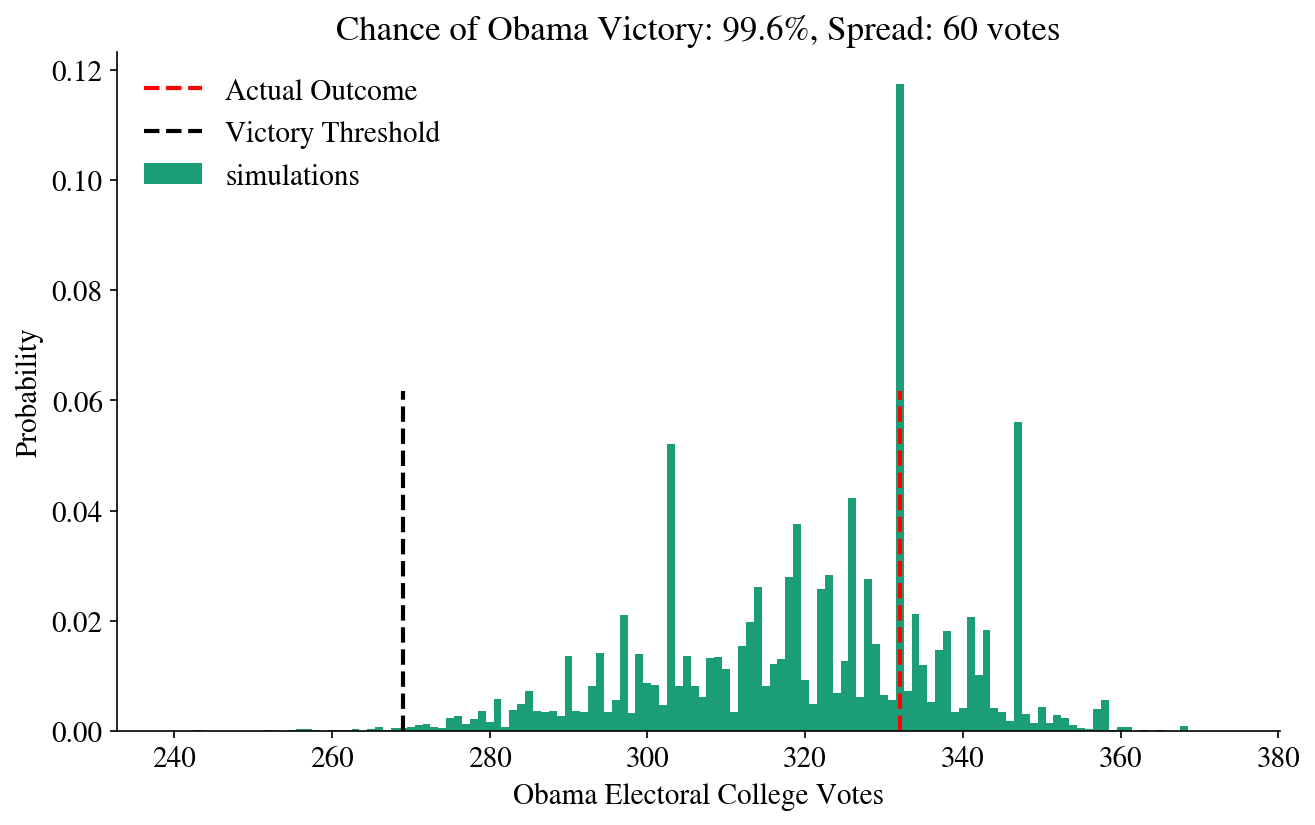

In [48]:
plot_simulation(result)

---

### Evaluating and Validating our Forecast

The goal of creating a probabilistic predictive model is to simultaneously  :

- make a forecast
- and give an estimate of how certain we are about it.

To trust our prediction or our reported level of uncertainty, the model needs to be **correct**.

A model is **correct** if it honestly accounts for `all of the mechanisms of variation` in the system we're forecasting.

The above histogram shows a hypothesis test.
It approximates the predictive distribution of election outcomes (in terms of electoral votes) `assuming our model for the election is true`.


---

### Gallup Party Affiliation Poll

We try to estimate our own win probabilities to plug into our predictive model, starting with a simple forecast model.

We will try to predict the outcome of the election based the estimated proportion of people in each state who identify with one political party or the other.

**Gallup** measures the political leaning of each state, based on asking random people which party they identify or affiliate with. 

Here's the [data](http://www.gallup.com/poll/156437/heavily-democratic-states-concentrated-east.aspx#2) they collected from January-June of 2012:

In [6]:
gallup_2012["Unknown"] = 100 - gallup_2012.Democrat - gallup_2012.Republican
gallup_2012.head()

,Democrat,Republican,Dem_Adv,N,Unknown
State,,,,,
Alabama,36.0,49.6,-13.6,3197,14.4
Alaska,35.9,44.3,-8.4,402,19.8
Arizona,39.8,47.3,-7.5,4325,12.9
Arkansas,41.5,40.8,0.7,2071,17.7
California,48.3,34.6,13.7,16197,17.1


This survey can be used to predict the outcome of each State's election.

The simplest forecast model assigns 100% probability that the state will vote for the majority party.

In [10]:
# check the code
simple_gallup_model(gallup_2012).head()

,Obama
State,
Alabama,0.0
Alaska,0.0
Arizona,0.0
Arkansas,1.0
California,1.0


In [20]:
# we run the simulation with this model, and plot it.
model = simple_gallup_model(gallup_2012)
# add the number of electoral votes perstate as a column
model = model.merge(electoral_votes, on='State')
prediction = simulate_election(model, 10000)
prediction

array([334, 334, 334, ..., 334, 334, 334])

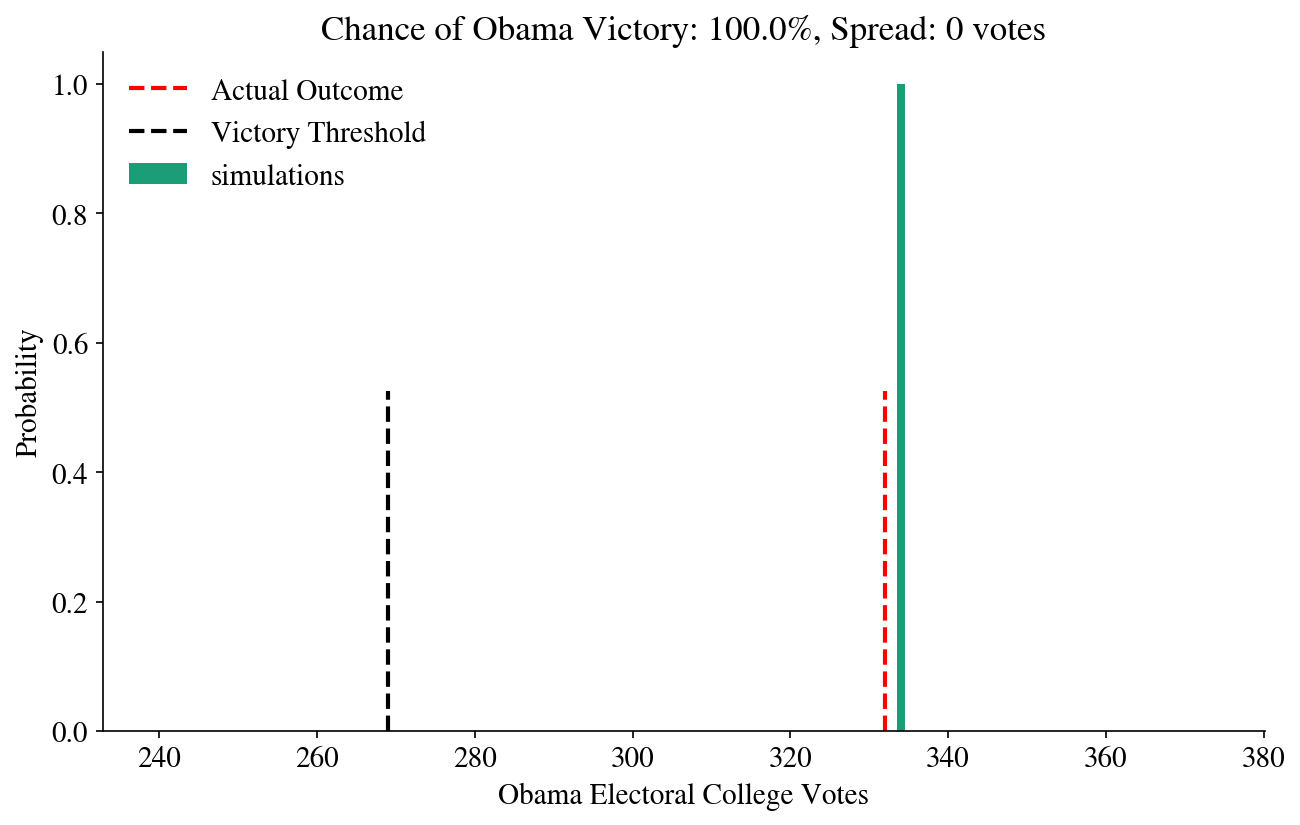

In [21]:
plot_simulation(prediction)

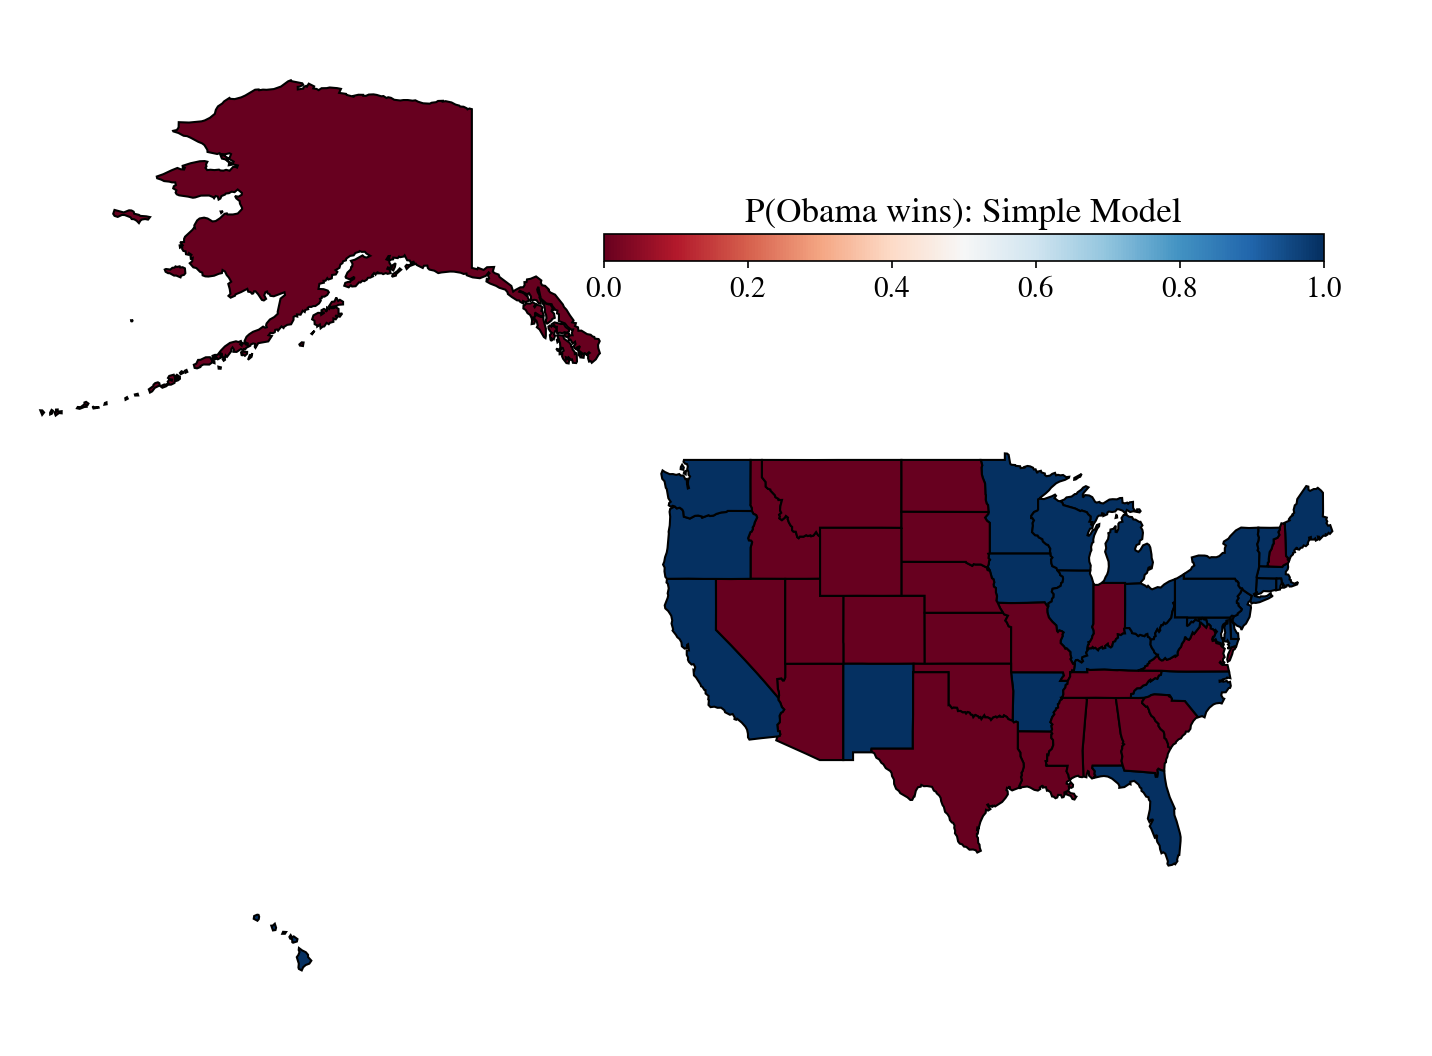

In [22]:
make_map(model.Obama, 'P(Obama wins): Simple Model')

### Model Validation
*`Does the evidence contradict the predictive model?`*

We do not predict the exactly correct result (red line). According to the predictive model (which presumes zeor uncertainty), the true outcome has probability 0. 

Thus, the evidence contradicts the predictive model, and we should reject it.


### Adding Polling Uncertainty to the Predictive Model

The model above is brittle -- it includes no accounting for uncertainty, and thus makes predictions with 100% confidence. 

There are numerous sources of `uncertainty` in estimating election outcomes from a poll of affiliations.

The most obvious source of error in the Gallup data is the `finite sample size`.

***How much uncertainty does this introduce?***

On their [webpage](http://www.gallup.com/poll/156437/heavily-democratic-states-concentrated-east.aspx#2) discussing these data, Gallup notes that the `sampling error` for the states is between 3 and 6%, with it being `3%` for most states.

- Use Gallup's estimate of 3% to build a Gallup model with some uncertainty. 

Assume that the `Dem_Adv` column represents the `mean of a Gaussian`, whose `standard deviation` is **3%**.

- `Complementary Cumulative Distribution Function` (**CCDF**)  or 
- `Survival Function` (**SF**)  or
- Tail Disitrbution / Exceedance  or

The probability that a sample from a Gaussian with mean $\mu$ and standard deviation $\sigma$ exceeds a threhold $z$ can be found using the the Complementary Cumulative Distribution Function (CCDF) or Survival Function (SF) of a Gaussian:

$$CCDF(z) = 1 - CDF(z) = 1 - \frac1{2}\left(1 + {\rm erf}\left(\frac{z - \mu}{\sqrt{2 \sigma^2}}\right)\right) $$ 

In [11]:
# test the code
uncertain_gallup_model(gallup_2012).head()

,Obama
State,
Alabama,0.000003
Alaska,0.002555
Arizona,0.006210
Arkansas,0.592249
California,0.999998


In [12]:
# construct the model by estimating the probabilities
model = uncertain_gallup_model(gallup_2012)
# add the number of electoral votes perstate as a column
model = model.merge(electoral_votes, on='State')

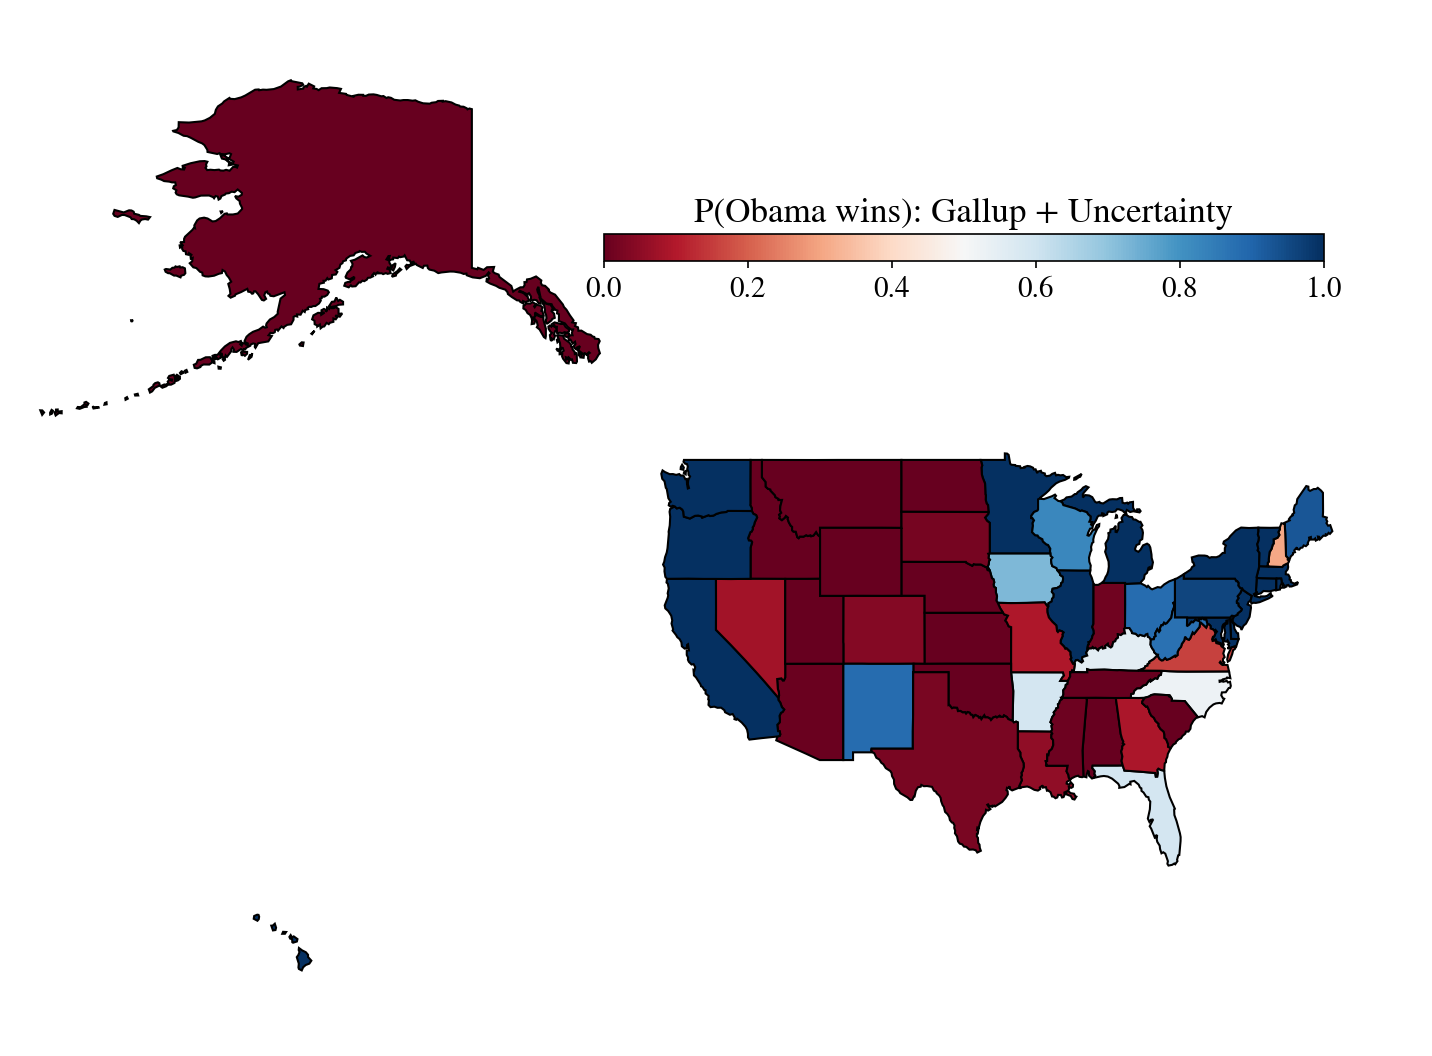

In [18]:
# we plot a map of these probabilities, 
make_map(model.Obama, "P(Obama wins): Gallup + Uncertainty")

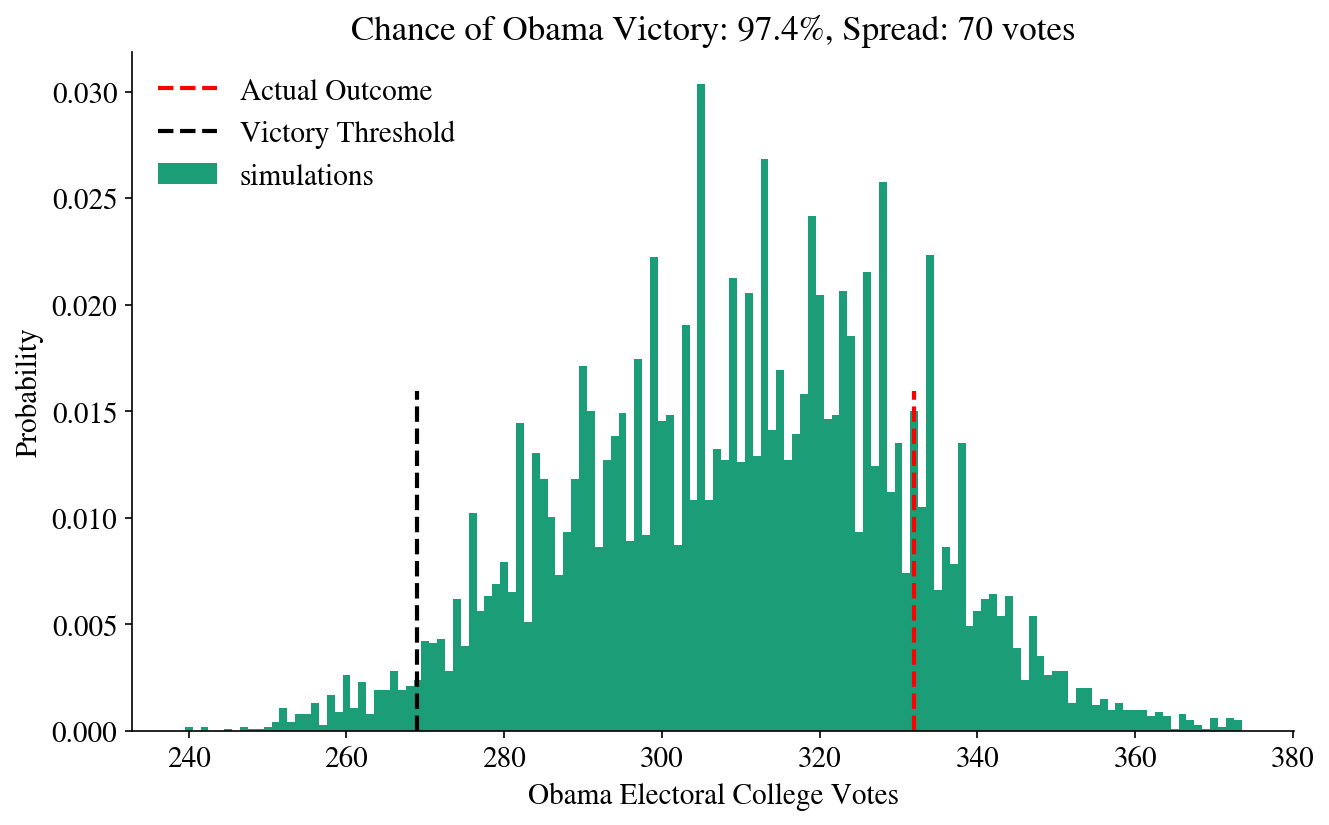

In [13]:
# we run the simulation, and display the results
prediction = simulate_election(model, 10000)
plot_simulation(prediction)

### Model Validation
*`Does the evidence contradict the predictive model?`*

The predictive distribution is consistent with the real data ; the real outcome seems like a typical outcome according to the model. 

The `accuracy` is not very good as the center of the distribution falls fairly far from the observed outcome, but the `precision` is only marginally worse than in the predictwise case.


---

### Biases

We call systematic over- or under-estimation of an unknown quantity **bias**. 

In the case of this forecast, our predictions would be biased if the estimates from this poll systematically over- or under-estimate vote proportions on election day.
Reasons for this are :
- **Gallup is wrong.** Poll systematically over- or under-estimates party affiliation.
    - People who answer are not a representative sample of people who actually vote, 
    - Gallup's methodology is flawed / people lie during the poll.
- **Our assumption about party affiliation is wrong**. Party affiliation may systematically over- or under-estimate vote proportions. 
    - people identify with one party, but strongly prefer the candidate from the other party,
    - undecided voters do not end up splitting evenly between Democrats and Republicans on election day.
- **Our assumption about equilibrium is wrong.** 
    - This poll was released in August, more than 2 months left for the elections. A trend in the way people change their affiliations during this time period (1 candidate is much worse at televised debates), an estimate in August could systematically miss the true value in November.

One way to account for bias is to calibrate our model by `estimating the bias and adjusting for it`. 

Before we do this, let's explore how sensitive our prediction is to bias.

In [12]:
# test code
biased_gallup(gallup_2012, 1.).loc['Florida']

Obama    0.460172
Name: Florida, dtype: float64

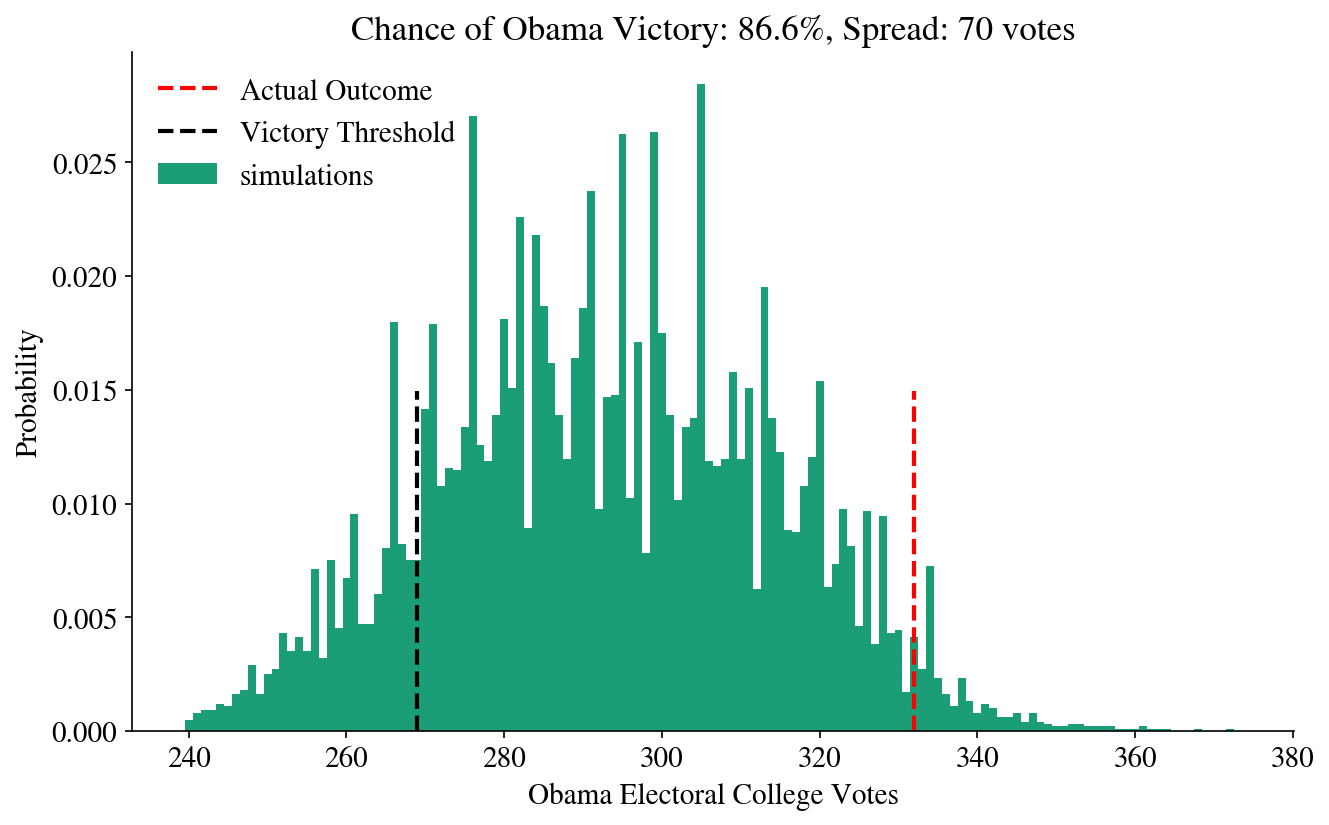

In [18]:
# Simulate elections assuming a bias of 1% and 5%,  
# plot histograms for each one.
# 1% bias
model1 = biased_gallup(gallup_2012, 1)
model1 = model1.join(electoral_votes)
prediction1 = simulate_election(model1, 10000)
plot_simulation(prediction1)

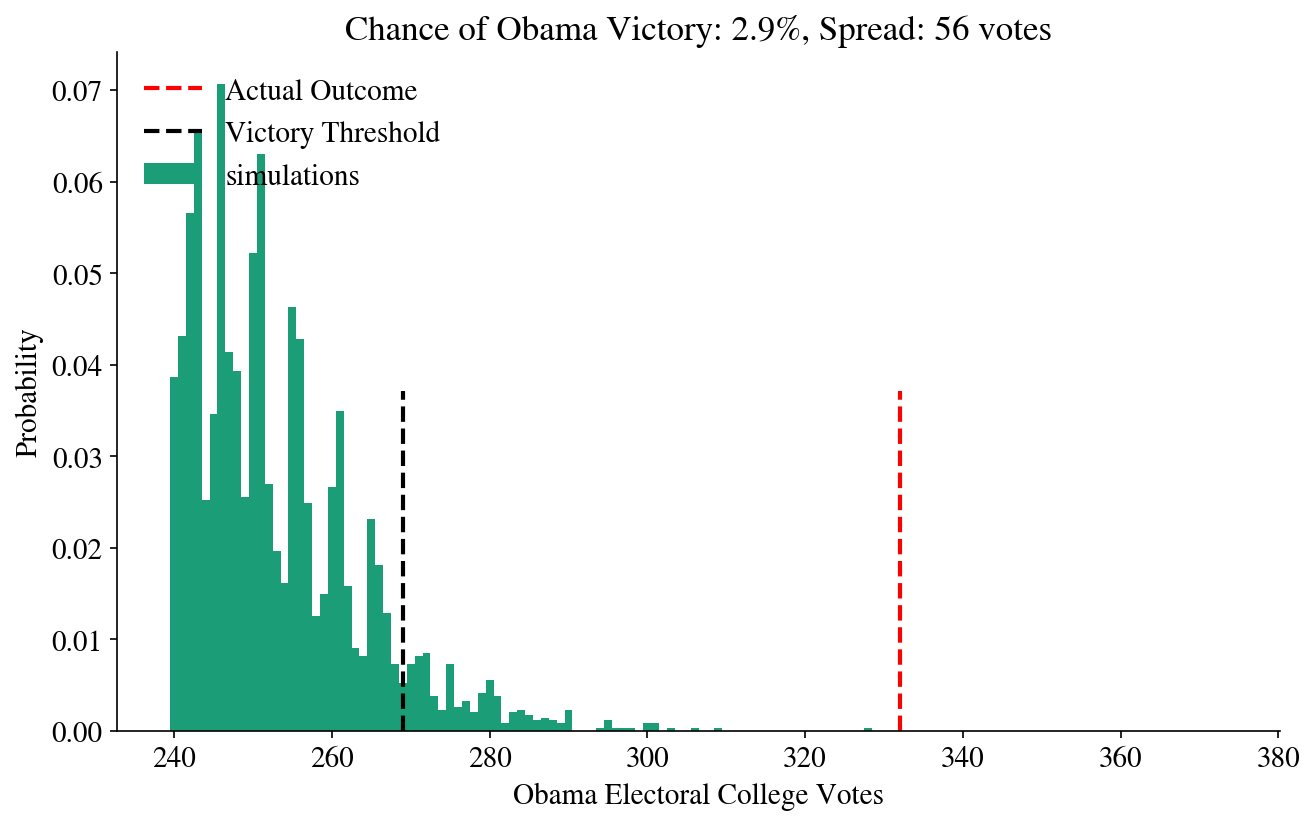

In [20]:
# 5% bias
model5 = biased_gallup(gallup_2012, 5)
model5 = model5.join(electoral_votes)
prediction5 = simulate_election(model5, 10000)
plot_simulation(prediction5)

`Even a small bias can have a dramatic effect on the predictions , more so due to the nature of the electoral college.`

Example : suppose you mis-predict the party `Florida` (29 votes) elects ; the penalty for even one misprediction is high (58 votes).


### Estimating the size of the bias from the 2008 election

While bias can lead to serious inaccuracy in our predictions, it is fairly easy to correct if we are able to `estimate the size of the bias and adjust for it`. This is one form of `calibration`.

One approach to calibrating a model is to `use historical data to estimate the bias of a prediction model`. Under some assumptions, we can use the estimate of the bias to adjust our current forecast.

Here we will use the Gallup data from the `2008` election.

In [9]:
gallup_08.head()

,Democrat,Republican,Dem_Adv,N
State,,,,
Alabama,43.9,44.7,-0.8,5499
Alaska,36.6,47.2,-10.6,1262
Arizona,42.8,43.2,-0.4,7660
Arkansas,49.1,36.6,12.5,3577
California,52.2,32.8,19.4,37098


In [15]:
results_08.head()

,Obama,McCain,Nader,Barr,Baldwin,McKinney,Others,Total,Unnamed: 9,Obama Pct,McCain Pct,O Rounded,M Rounded
State,,,,,,,,,,,,,
Alabama,"813,479","1,266,546","6,788","4,991","4,310",0,"3,705","2,099,819",NaN,38.74,60.32,39,60
Alaska,"123,594","193,841","3,783","1,589","1,660",0,"1,730","326,197",NaN,37.89,59.42,38,59
Arizona,"1,034,707","1,230,111","11,301","12,555","1,371","3,406",24,"2,293,475",NaN,45.12,53.64,45,54
Arkansas,"422,310","638,017","12,882","4,776","4,023","3,470","1,139","1,086,617",NaN,38.86,58.72,39,59
California,"8,274,473","5,011,781","108,381","67,582","3,145","38,774","57,764","13,561,900",NaN,61.01,36.95,61,37


In [11]:
prediction_08 = gallup_08[['Dem_Adv']]
prediction_08['Dem_Win'] = results_08["Obama Pct"] - results_08["McCain Pct"]
prediction_08.head()

/archive/Studies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Dem_Adv,Dem_Win
State,,
Alabama,-0.8,-21.58
Alaska,-10.6,-21.53
Arizona,-0.4,-8.52
Arkansas,12.5,-19.86
California,19.4,24.06


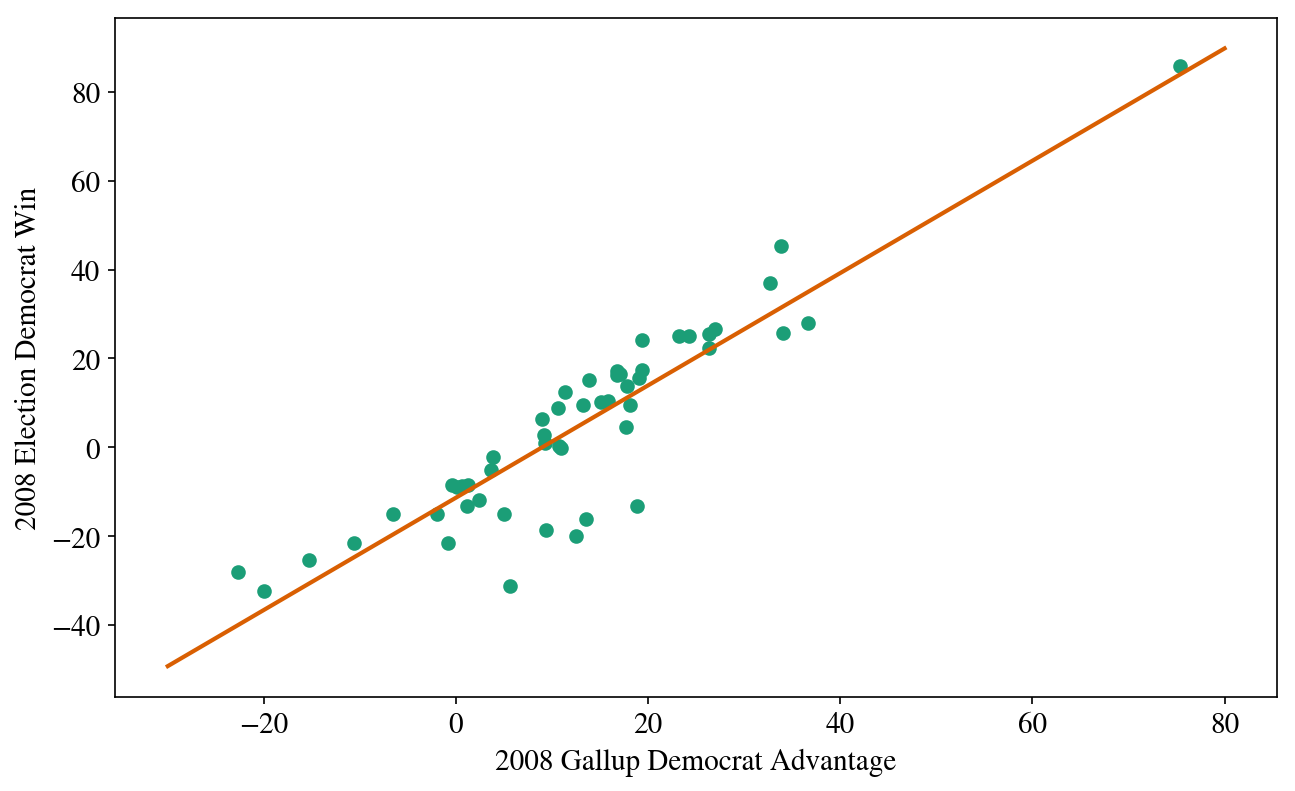

In [36]:
# Scatter plot of :
# 2008 Gallup Dem_Adv  poll (X axis) vs
# 2008 Dem_Win percentage diff Obama/McCain votes per state (Y Axis). 
# Overplot a linear fit to these data.

_ = plt.plot(prediction_08.Dem_Adv, prediction_08.Dem_Win, 'o')
plt.xlabel("2008 Gallup Democrat Advantage")
plt.ylabel("2008 Election Democrat Win")

# The np.polyfit function can compute linear fits,
# as can sklearn.linear_model.LinearModel
fit = np.polyfit(prediction_08.Dem_Adv, prediction_08.Dem_Win, 1)
x = np.linspace(-30, 80, 10)
# Evaluate a polynomial at specific values.
y = np.polyval(fit, x)
_ = plt.plot(x, y)

In [37]:
# show a number of states where Gallup showed Dems leading, 
# but where were won by the GOP.
prediction_08[(prediction_08.Dem_Adv > 0) & (prediction_08.Dem_Win < 0)]

,Dem_Adv,Dem_Win
State,,
Arkansas,12.5,-19.86
Georgia,3.6,-5.21
Kentucky,13.5,-16.23
Louisiana,9.4,-18.63
Mississippi,1.1,-13.18
Missouri,10.9,-0.14
Montana,3.9,-2.26
North Dakota,0.6,-8.63
Oklahoma,5.6,-31.30


`We compute the average difference between the Dems lead in the Gallup poll and the actual vote lead in the election.`

In [39]:
(prediction_08.Dem_Adv - prediction_08.Dem_Win).mean()

8.07

#### **Calibrate** your `forecast of the 2012 election` using the `estimated bias from 2008`. 

#### Validate the resulting model against the real 2012 outcome.

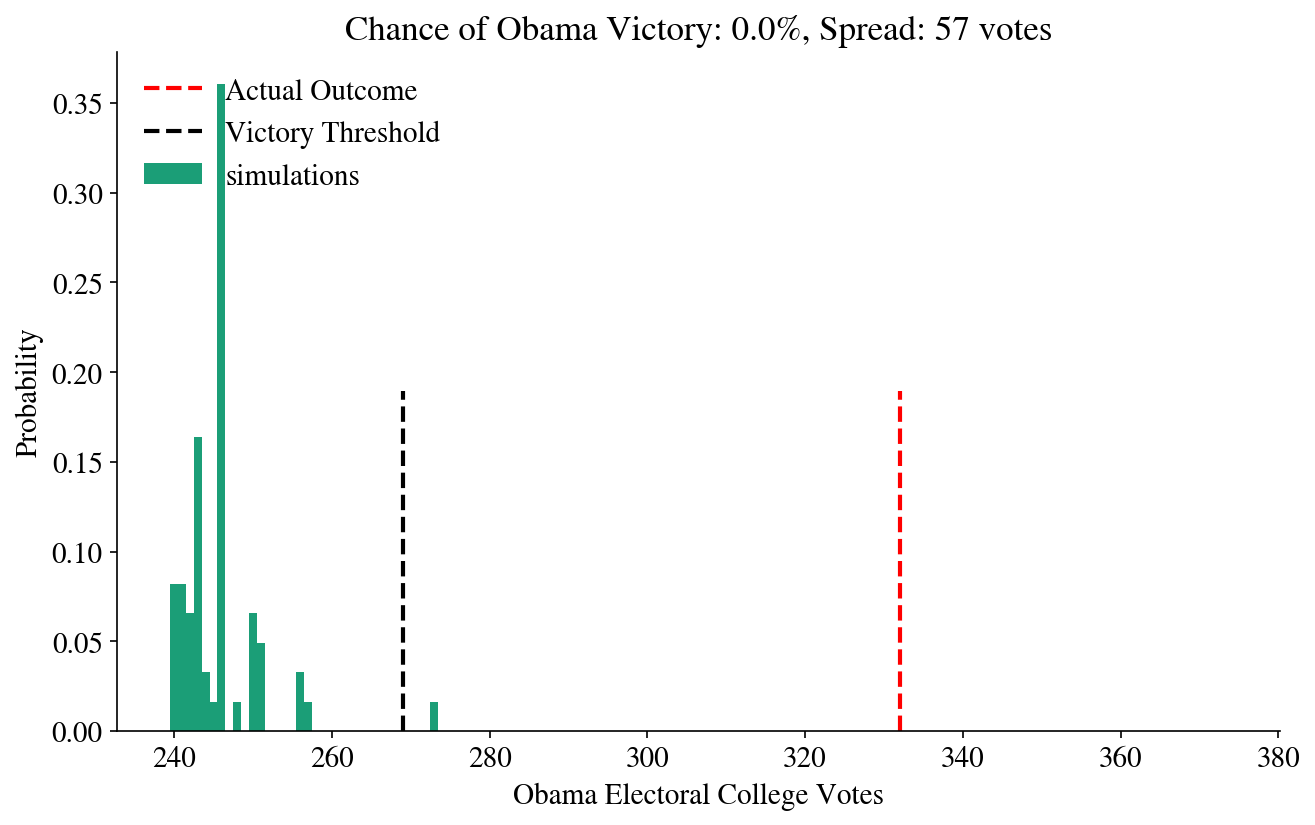

In [17]:
model = biased_gallup(gallup_2012, 8.06)
model = model.join(electoral_votes)
prediction = simulate_election(model, 10000)
plot_simulation(prediction)

### Disaster  £@!! 

The `8% calibration` completely destroys the accuracy of our prediction in 2012.
Our calibration made the assumptions that :
- a) `the bias in 2008 was the same as 2012`
, and 
- b) `the bias in each state was the same`.

***It might have been better to callibrate the bias on a state-wide or clustered basis.***

***Q: Should you trust the results of an election forecast based on the 2012 Gallup party affiliation poll?***

**A**: `No`. The results from 2008 would suggest that `the party affiliation poll is a highly biased predictor` of the actual election outcome. 

Given that calibrating the model `to counteract this bias would rely on unrealistic assumptions`, it would seem unwise to use the 2012 party affiliation poll to predict the election.

---

## Logistic Considerations

In the previous forecast, we posited that the vote outcome is deterministically related to estimated partisan affiliation.

Next up, we will employ  multiple `features (estimators)` to perform our predictions. Such estmators may include demographic data, exit poll data, and data from previous elections.

We'll construct a new feature called `PVI`, and use it and the Gallup poll to build predictions. 
Then, we'll use `logistic regression` to estimate win probabilities, and use these probabilities to build a prediction.

***The Partisan Voting Index (PVI)*** is defined as `the excessive swing towards a party in the previous election in a given state`, i.e.

$$ PVI_{2008} (state) = (Dem-GOP)\%_{2004} (state) - (Dem-GOP)\%_{2004} (national) $$

In [12]:
#  load the national % results for both parties in the last 3 elections
national_results=pd.read_csv("../data/hw2_data/nat.csv")
national_results.set_index('Year',inplace=True)
national_results.head()

,Dem,Rep
Year,,
2004,48,51
2008,53,46
2012,51,47


In [13]:
#data on 2004 elections from p04.csv 
#same form for the 2004 election for each state.
polls04=pd.read_csv("../data/hw2_data/p04.csv")
polls04.State=polls04.State.replace(states_abbrev)
polls04.set_index("State", inplace=True);
polls04.head()

,Dem,Rep
State,,
Alabama,37,63
Alaska,34,62
Arizona,44,55
Arkansas,45,54
California,54,45


In [15]:
# compute state's PVI for the 08 elections 
nat = national_results.loc[2004].Dem - national_results.loc[2004].Rep
pvi08 = polls04.Dem - polls04.Rep - nat
pvi08.head()

State
Alabama      -23
Alaska       -25
Arizona       -8
Arkansas      -6
California    12
dtype: int64

#### Dataframe e2008 
Cols :

- `pvi` : the partisan vote index pvi08
- `Dem_Adv` : the Democratic advantage from prediction_08 with `the mean subtracted out`
- `obama_win` 1 for each state Obama won in 2008, and 0 otherwise
- `Dem_Win` the 2008 election Obama percentage minus McCain percentage, also from the frame `prediction_08`

***The DataFrame should be indexed and sorted by State.***


In [16]:
e2008=pd.DataFrame(dict(pvi=pvi08, 
                        Dem_Win = prediction_08.Dem_Win, 
                        Dem_Adv=prediction_08.Dem_Adv-prediction_08.Dem_Adv.mean()))

e2008['obama_win'] = (e2008.Dem_Win > 0).astype('int')

e2008.sort_index(inplace=True)
e2008.head()

,pvi,Dem_Win,Dem_Adv,obama_win
State,,,,
Alabama,-23,-21.58,-13.154902,0
Alaska,-25,-21.53,-22.954902,0
Arizona,-8,-8.52,-12.754902,0
Arkansas,-6,-19.86,0.145098,0
California,12,24.06,7.045098,1


### Dataframe e2012

- `Same structure as e2008` ; 

- No `obama_win` column ; ***our goal is to predict it!!!***


In [17]:
pvi12 = e2008.Dem_Win - (national_results.loc[2008]['Dem'] - 
                         national_results.loc[2008]['Rep'])
e2012 = pd.DataFrame(dict(pvi=pvi12, 
                          Dem_Adv=gallup_2012.Dem_Adv - gallup_2012.Dem_Adv.mean()))
e2012.sort_index(inplace=True)
e2012.head()

,pvi,Dem_Adv
State,,
Alabama,-28.58,-14.684314
Alaska,-28.53,-9.484314
Arizona,-15.52,-8.584314
Arkansas,-26.86,-0.384314
California,17.06,12.615686


#### We load the actual 2012 results to compare with our predictions.

In [18]:
results2012 = pd.read_csv("../data/hw2_data/2012results.csv")
results2012.set_index("State", inplace=True)
results2012.sort_index(inplace=True)
results2012.head()

,Winner
State,
Alabama,0
Alaska,0
Arizona,0
Arkansas,0
California,1


### Exploratory Data Analysis

`Is the partisan vote index relatively stable from election to election?`

- ***Plot a scatter plot of the two `PVI`'s against each other***

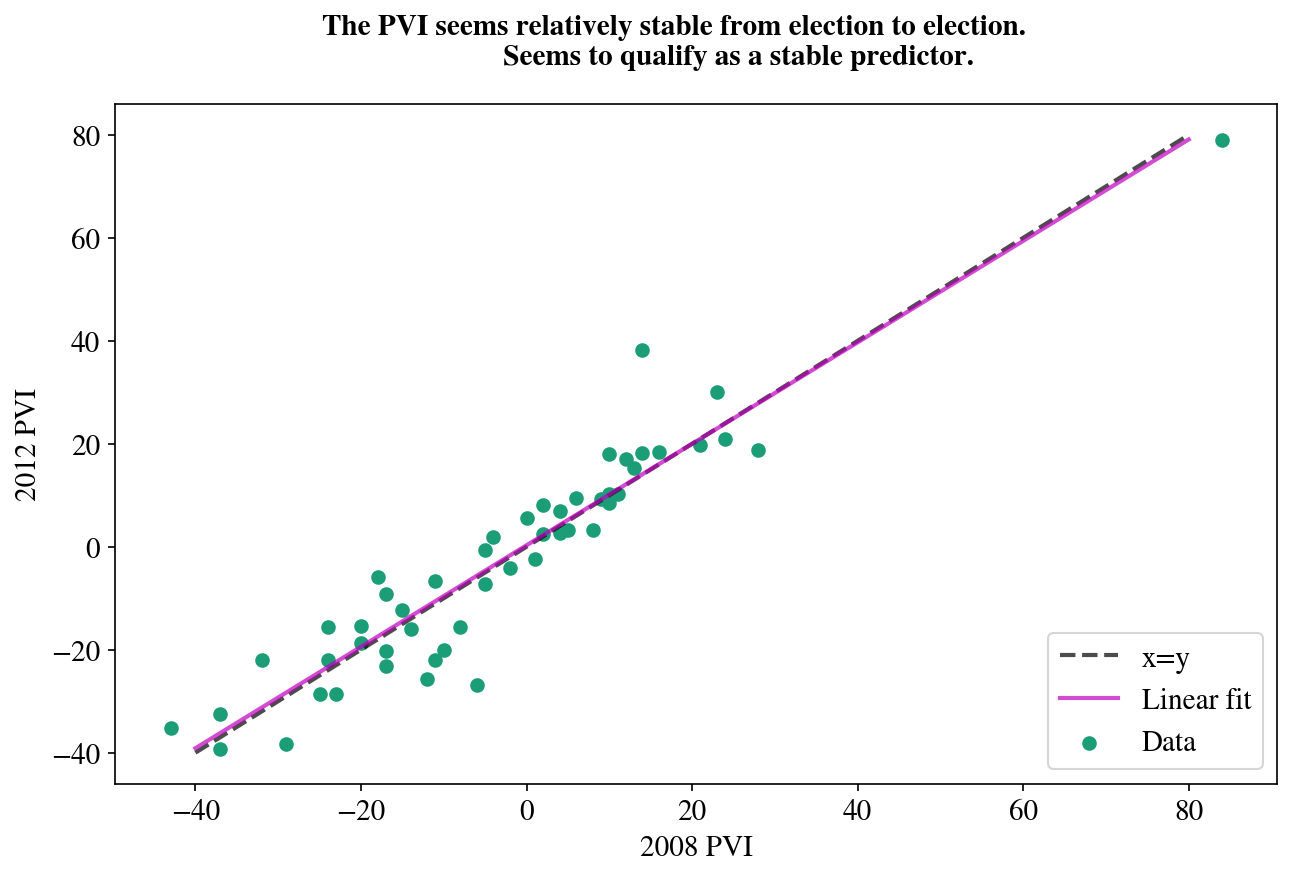

In [49]:
fig, ax = plt.subplots()
# fitting a Linear Regression model
fit = np.polyfit(e2008.pvi, e2012.pvi, 1)
x = np.linspace(-40, 80, 10)
# our LinReg estimators
y = np.polyval(fit, x)
# the black line corresponds to perfect (1:1) correlation
ax.plot(x, x, '--k', alpha=.7, label='x=y')
# Linear Regression Plot
ax.plot(x, y, 'm', alpha=.7, label='Linear fit')
# scatter plot between PVIs
ax.scatter(pvi08, pvi12, label='Data')
ax.set(xlabel ='2008 PVI',
       ylabel = '2012 PVI')
ax.legend(loc='lower right')
_ =fig.suptitle('The PVI seems relatively stable from election to election. \n \
                Seems to qualify as a stable predictor.',
                fontsize=14, 
                fontweight='bold')
        

### EDA contd
Using a scatter plot, plot `Dem_Adv` against `pvi` in both 2008 and 2012. 

Use colors `red` and `blue` depending upon `obama_win` for the 2008 data points. 

Plot the 2012 data using `gray` color. 

**Q:** `Is there the possibility of making a linear separation (aka line contour) between the red and the blue points on the graph?`

**A**: `Yes, it seems that with 3-4 misclassifications, we could draw a line to divide the data into two parts.`

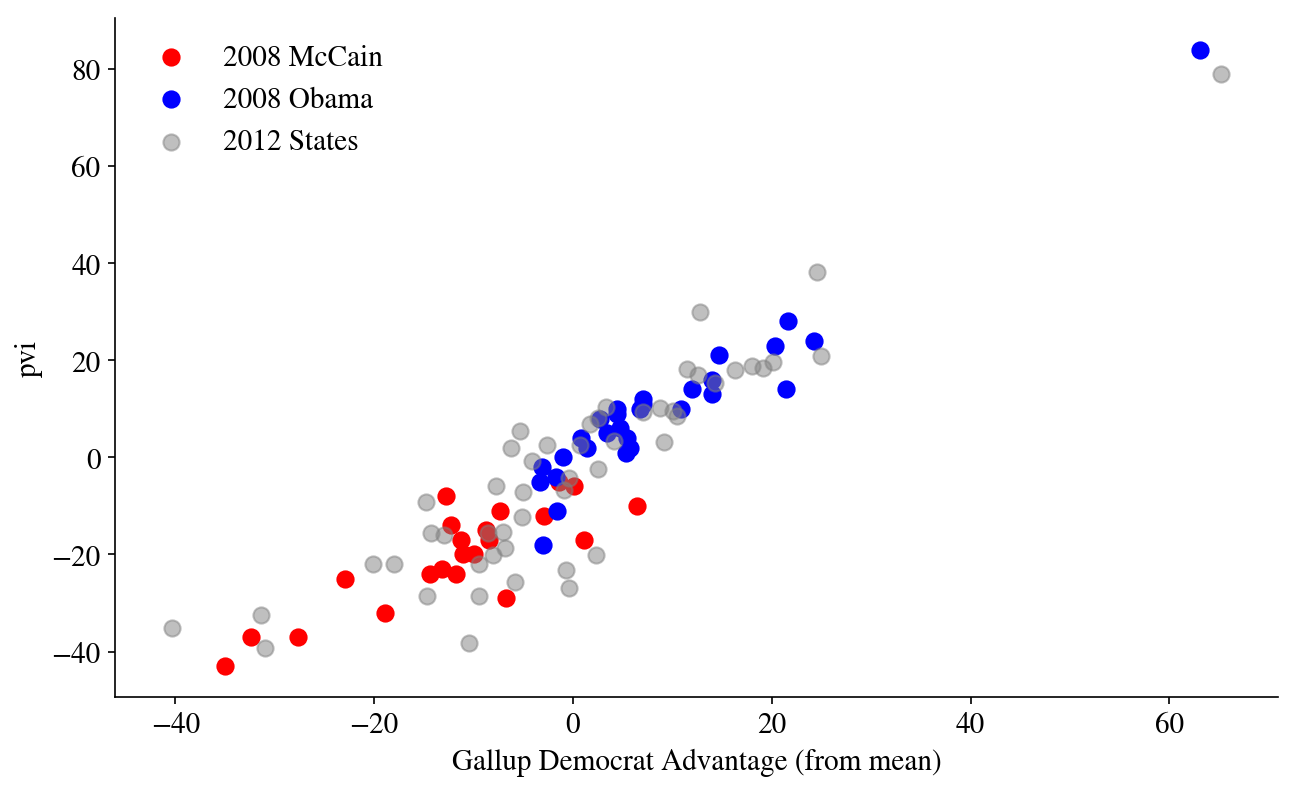

In [24]:
fig, ax  = plt.subplots()

colors=["red","blue"]
labels = ['2008 McCain', '2008 Obama']

# 2008 state wins for Obama / McCain
for pick in [0, 1]:
    color = colors[pick]
    label = labels[pick]
    mask = e2008.obama_win == pick
    ax.scatter(e2008[mask]['Dem_Adv'], e2008[mask]['pvi'], 
               c=color, s=60, label=label)
    ax.set(xlabel='Gallup Democrat Advantage (from mean)',
       ylabel='pvi')
# 2012 elections
ax.scatter(e2012['Dem_Adv'], e2012['pvi'], 
           c='gray', s=60, marker="o", 
           label='2012 States', alpha=.5)

ax.legend(frameon=False, scatterpoints=1, loc='upper left')
remove_border()

---

### The Logistic Regression

`Logistic regression is a probabilistic model that links observed binary data to a set of features.`

Suppose that we have a set of binary (0 or 1) observations $Y_1,\cdots,Y_n$, and for each observation $Y_i$ we have a vector of features $X_i$. 

The logistic regression model assumes that there is some set of **weights, coefficients, or parameters $\beta$**, one for each feature, so that the data were generated by flipping a weighted coin whose probability of giving a 1 is given by the following equation:
$$ P(Y_i = 1) = \mathrm{logistic}(\sum \beta_i X_i), $$

where
$$ \mathrm{logistic}(x) = \frac{e^x}{1+e^x}. $$


When we *fit* a logReg model, we determine values for each $\beta$ that allows the model to best fit the training data (the 2008 election). 
We then use these coefficients to make predictions about data we have not yet observed (the 2012 election).

Sometimes this estimation procedure will `overfit` the training data yielding predictions that are difficult to generalize to unobserved data. Usually, this occurs when `the magnitudes of the components of $\beta$ become too large`. To prevent this, we can use a technique called `regularization` to make the procedure prefer parameter vectors that have smaller magnitude. 

`We can adjust the strength of this regularization to reduce the error in our predictions.`

In sklearn's version of LogisticRegression, this is done via `C`.
The parameter C is a `hyperparameter` of the model, and is used to penalize too high values of the parameter `co-efficients` in the `loss function that is minimized to perform the logistic regression`.

In order to estimate C, we perform a `grid search` over many C to find `the best C that minimizes the loss function`. For each point on that grid, we carry out a `n_folds-fold cross-validation`. 

#### n_folds-fold cross-validation :
- Suppose `n_folds=10`. Then we will repeat the fit 10 times, `each time randomly choosing 50/10 ~ 5 states out as a test set`, and using the remaining 45/46 as the training set. 

We use the average score on the test set to score each particular choice of C, and choose the one with the best performance.

In [19]:
posterior12 , clf12 = fit_logistic(e2008, e2012, ['Dem_Adv', 'pvi']) 
posterior12.head()

,Obama
State,
Alabama,0.302766
Alaska,0.319762
Arizona,0.386522
Arkansas,0.358446
California,0.635655


#### Carry out a logistic fit using the `cv_and_fit` function developed (& found in hw2.py).
- As a featurelist use the features we have: `Dem_Adv` and `pvi`.

In [27]:
res, clf = cv_and_fit(e2008, e2012, ['Dem_Adv', 'pvi'])
predict2012_logistic = res.join(electoral_votes)
predict2012_logistic.head()

/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/archive/Studies/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

,Obama,Votes
State,,
Alabama,0.004367,9
Alaska,0.008462,3
Arizona,0.068250,11
Arkansas,0.033851,6
California,0.994326,55


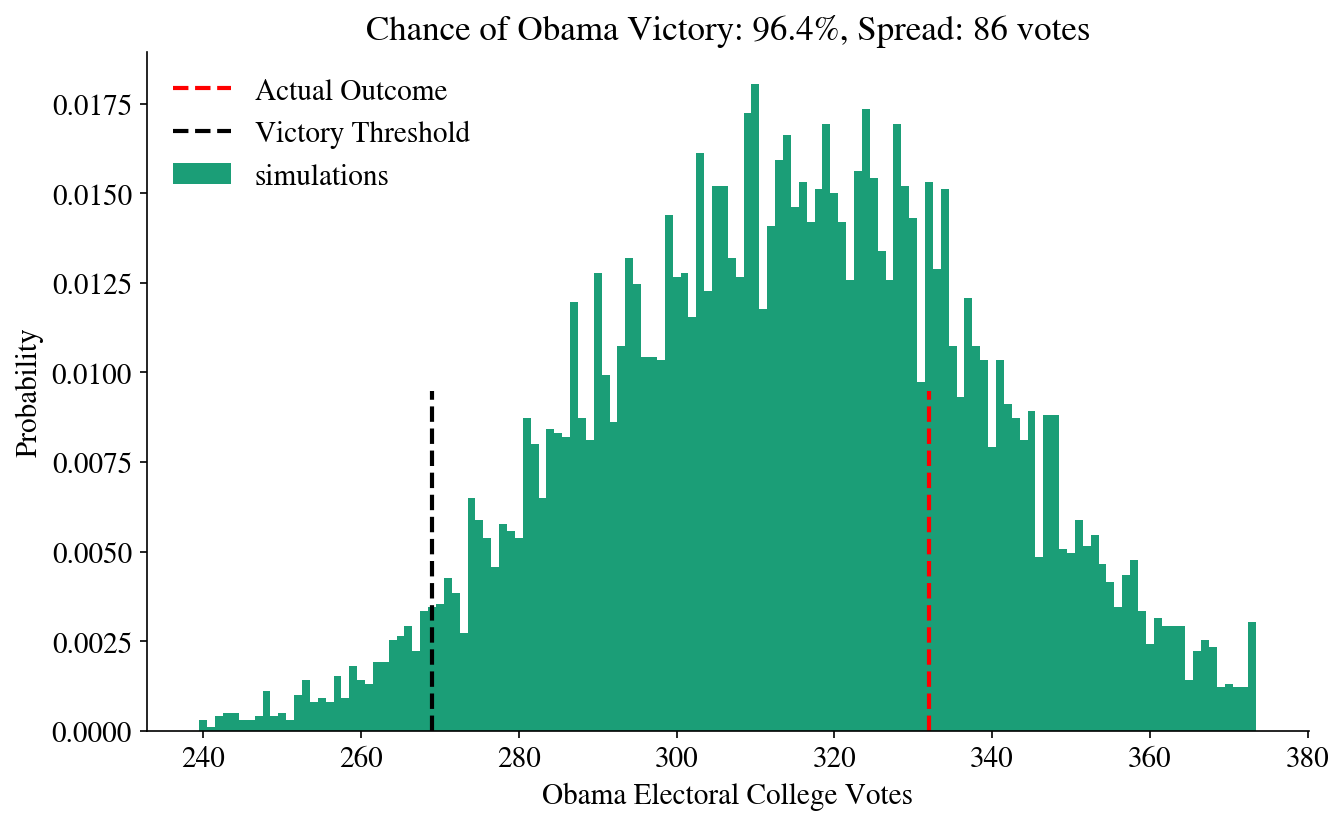

In [28]:
# plot a histogram and map of the simulation results, and 
# interpret the results in terms of accuracy and precision.
prediction = simulate_election(predict2012_logistic, 10000)
plot_simulation(prediction)

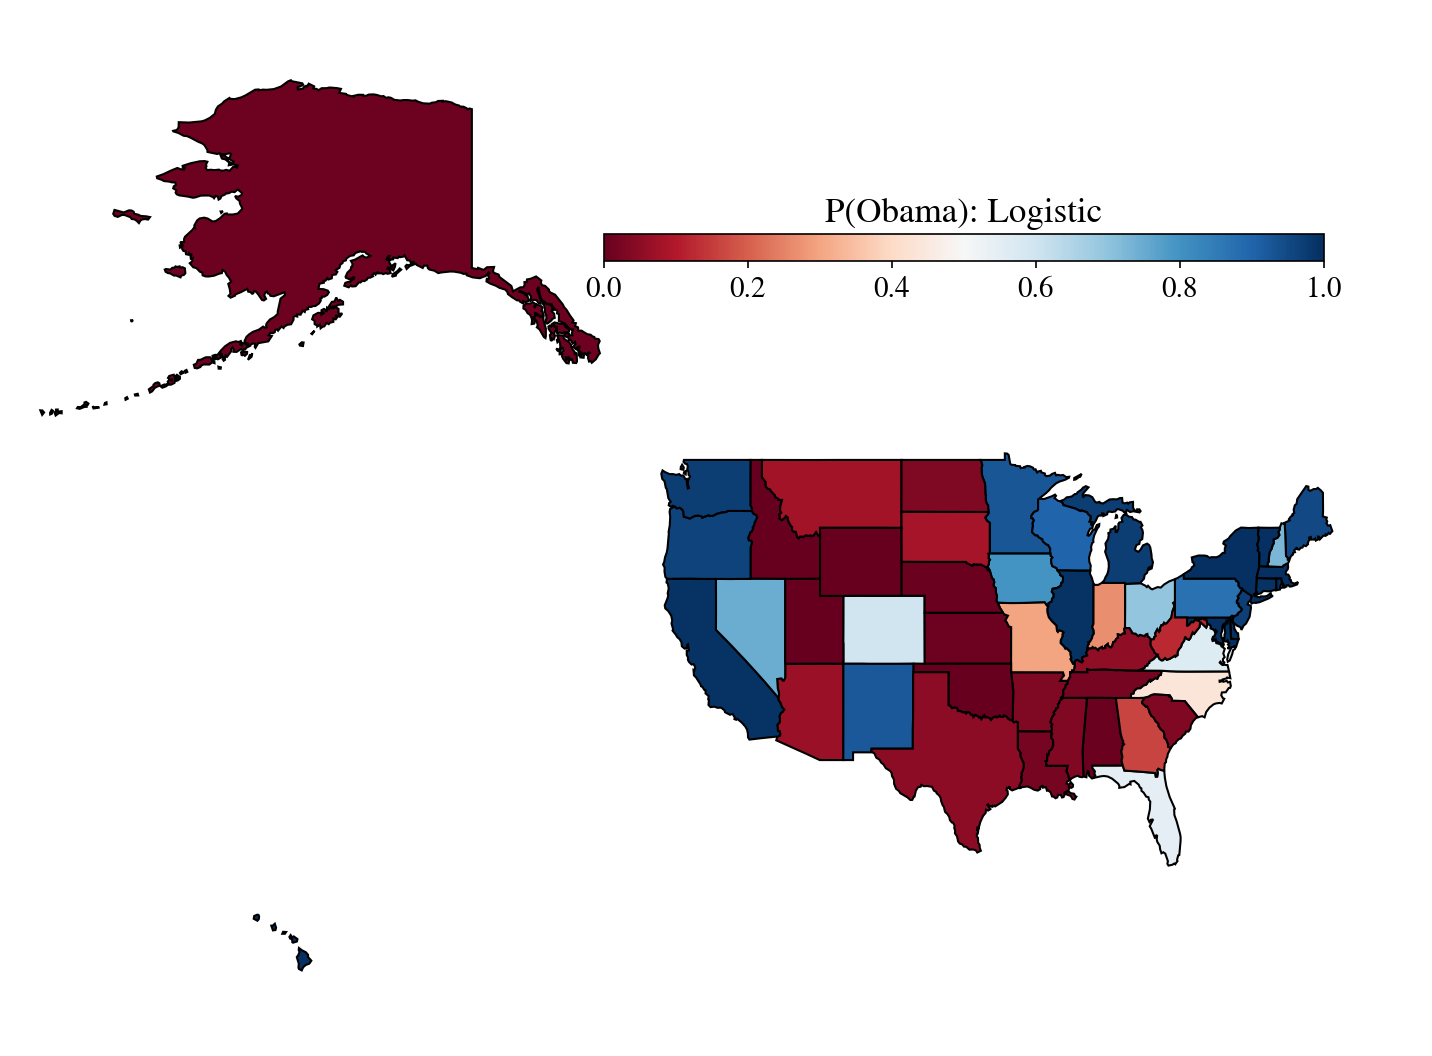

In [46]:
make_map(predict2012_logistic.Obama, "P(Obama): Logistic")

***Analysis :*** The precision has *worsened* with respect to the `predictwise` (and even the `gallup`) model. The accuracy has *improved* with respect to the gallup model, but is not as good as in the predictwise model.

---

### Classifier Decision boundary

One nice way to visualize a `2-dimensional logistic regression` is to plot the probability as a function of each dimension. This shows the `decision boundary` -- the set of parameter values where the logistic fit yields P=0.5, and shifts between a preference for Obama or McCain/Romney.

The function below draws such a figure (it is adapted from the scikit-learn website), and overplots the data.

Text(0, 0.5, 'PVI')

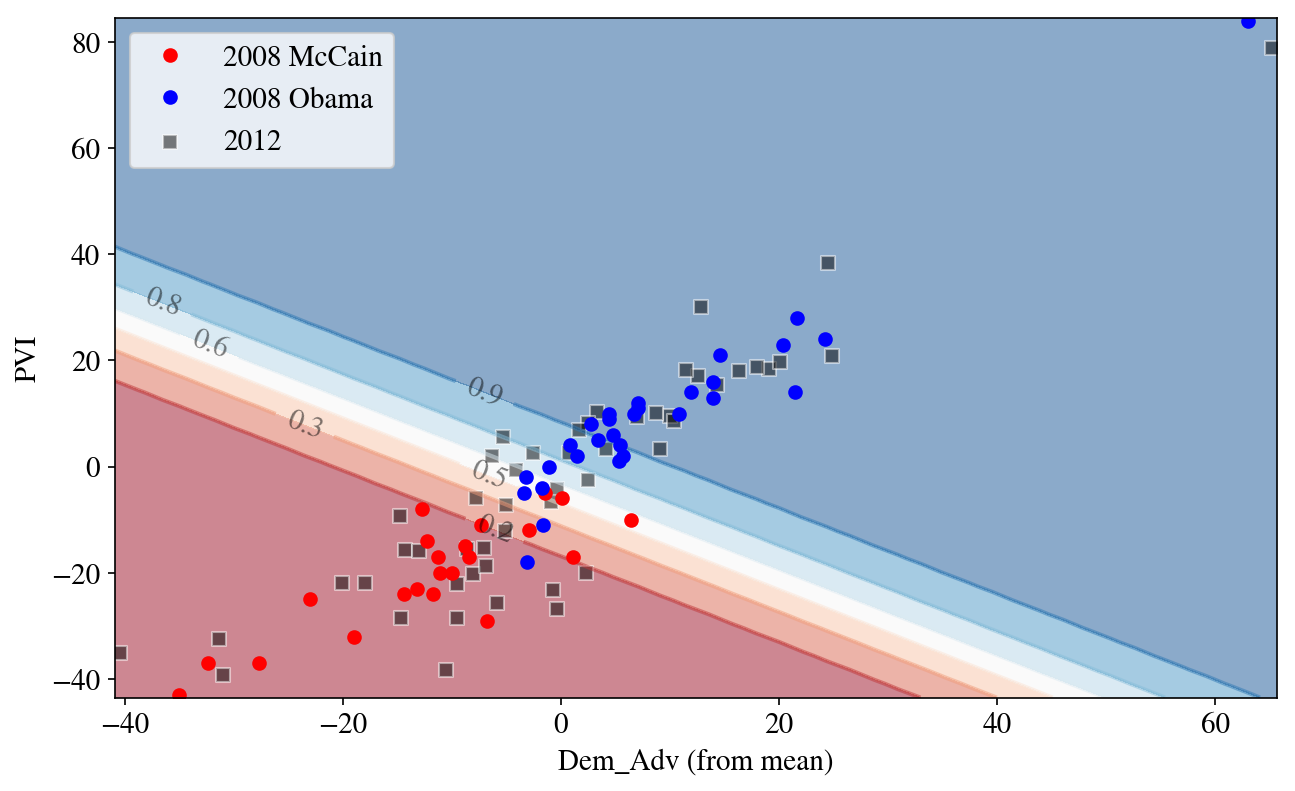

In [53]:
points_plot(e2008, e2012, clf)
plt.xlabel("Dem_Adv (from mean)")
plt.ylabel("PVI")

***Analysis***
- The sharpness of the classifier boundary, as defined by the closeness of the contours near a probability of 0.5 gives us a sense of precision.
- How many states fall smack into the middle, say between 0.3 and 0.7. The more that do, the less precise the results will be, as there will be a greater number of simulations in which they will cross-over to another party.

To assess accuracy, we would have to see the actual outcome of the states in 2012. `Accuracy would be a function of the number of states that end up on the "wrong" side of the 0.5 line`, and how deep they end up on the wrong side.

---

### Emulating Silver : Poll Aggregation

- The following table aggregates many of the pre-election polls available as of October 2, 2012. We are most interested in the column `obama_spread`.

In [55]:
multipoll = pd.read_csv('../data/hw2_data/cleaned-state_data2012.csv', 
                        index_col=0)

#convert state abbreviation to full name
multipoll.State.replace(states_abbrev, inplace=True)

#convert dates from strings to date objects
multipoll.start_date = multipoll.start_date.apply(pd.to_datetime)
multipoll.end_date = multipoll.end_date.apply(pd.to_datetime)
# compute midpoint date
multipoll['poll_date'] = multipoll.start_date + (multipoll.end_date - multipoll.start_date).values / 2

#compute the poll age relative to Oct 2, in days
multipoll['age_days'] = (today - multipoll['poll_date']).values / np.timedelta64(1, 'D')

#drop any rows with data from after oct 2
multipoll = multipoll[multipoll.age_days > 0]

#drop unneeded columns
multipoll.drop(['Date', 'start_date', 'end_date', 'Spread'], axis=1, inplace=True)

#add electoral vote counts
multipoll = multipoll.join(electoral_votes, on='State')

#drop rows with missing data
multipoll.dropna()

multipoll.head()

,Pollster,State,MoE,Obama (D),Romney (R),Sample,obama_spread,poll_date,age_days,Votes
0,Rasmussen Reports,Washington,4.5,52.0,41.0,500.0,11.0,2012-09-26 00:00:00,6.0,12
1,Gravis Marketing,Washington,4.6,56.0,39.0,625.0,17.0,2012-09-21 12:00:00,10.5,12
2,Elway Poll,Washington,5.0,53.0,36.0,405.0,17.0,2012-09-10 12:00:00,21.5,12
3,SurveyUSA,Washington,4.4,54.0,38.0,524.0,16.0,2012-09-08 00:00:00,24.0,12
4,SurveyUSA,Washington,4.4,54.0,37.0,524.0,17.0,2012-08-01 12:00:00,61.5,12


 `We compute a new data frame that averages the obama_spread for each state. Also compute the standard deviation of the obama_spread in each state, and the number of polls for each state.`

In [83]:
ms = multipoll.groupby('State').aggregate({'obama_spread':[np.mean,np.std, np.size]})
df = ms.obama_spread.rename(columns={'mean':'poll_mean',
                                     'std':'poll_std',
                                     'size':'N'})
avg = df.join(electoral_votes, how='outer')
avg.head()

,poll_mean,poll_std,N,Votes
State,,,,
Alabama,NaN,NaN,NaN,9
Alaska,NaN,NaN,NaN,3
Arizona,-5.500000,4.559548,20.0,11
Arkansas,-20.333333,4.041452,3.0,6
California,18.950000,5.548589,20.0,55


Some of the reddest and bluest states are not present in this data (people don't bother polling there as much). 
The `default_missing` function gives them strong Democratic/Republican advantages.

In [84]:
def default_missing(results):
    red_states = ["Alabama", "Alaska", "Arkansas", "Idaho", "Wyoming"]
    blue_states = ["Delaware", "District of Columbia", "Hawaii"]
    results.loc[red_states, ["poll_mean"]] = -100.0
    results.loc[red_states, ["poll_std"]] = 0.1
    results.loc[blue_states, ["poll_mean"]] = 100.0
    results.loc[blue_states, ["poll_std"]] = 0.1
default_missing(avg)
avg.head()

,poll_mean,poll_std,N,Votes
State,,,,
Alabama,-100.00,0.100000,NaN,9
Alaska,-100.00,0.100000,NaN,3
Arizona,-5.50,4.559548,20.0,11
Arkansas,-100.00,0.100000,3.0,6
California,18.95,5.548589,20.0,55


We build an `aggregated_poll_model` function that takes the `avg` DataFrame as input, and returns a `forecast` DataFrame in the format you've been using to simulate elections. 

Assume that the probability that `Obama wins a state` is given by the probability that a draw from a Gaussian with $\mu=$poll_mean and $\sigma=$poll_std is `positive`.

In [85]:
def aggregated_poll_model(polls):
    sigma = polls.poll_std
    prob =  1 - .5 * (1 + erf(-1*polls.poll_mean / np.sqrt(2 * sigma ** 2)))
    return pd.DataFrame(dict(Obama=prob, Votes=polls.Votes))

/archive/Studies/DataScience/Courses/Harvard-CS109_Data_Science/CS109_2013/notebooks/homework/hw2.py:198: RuntimeWarning: invalid value encountered in less
  model.Obama.values.reshape(-1, 1)


(250, 400)

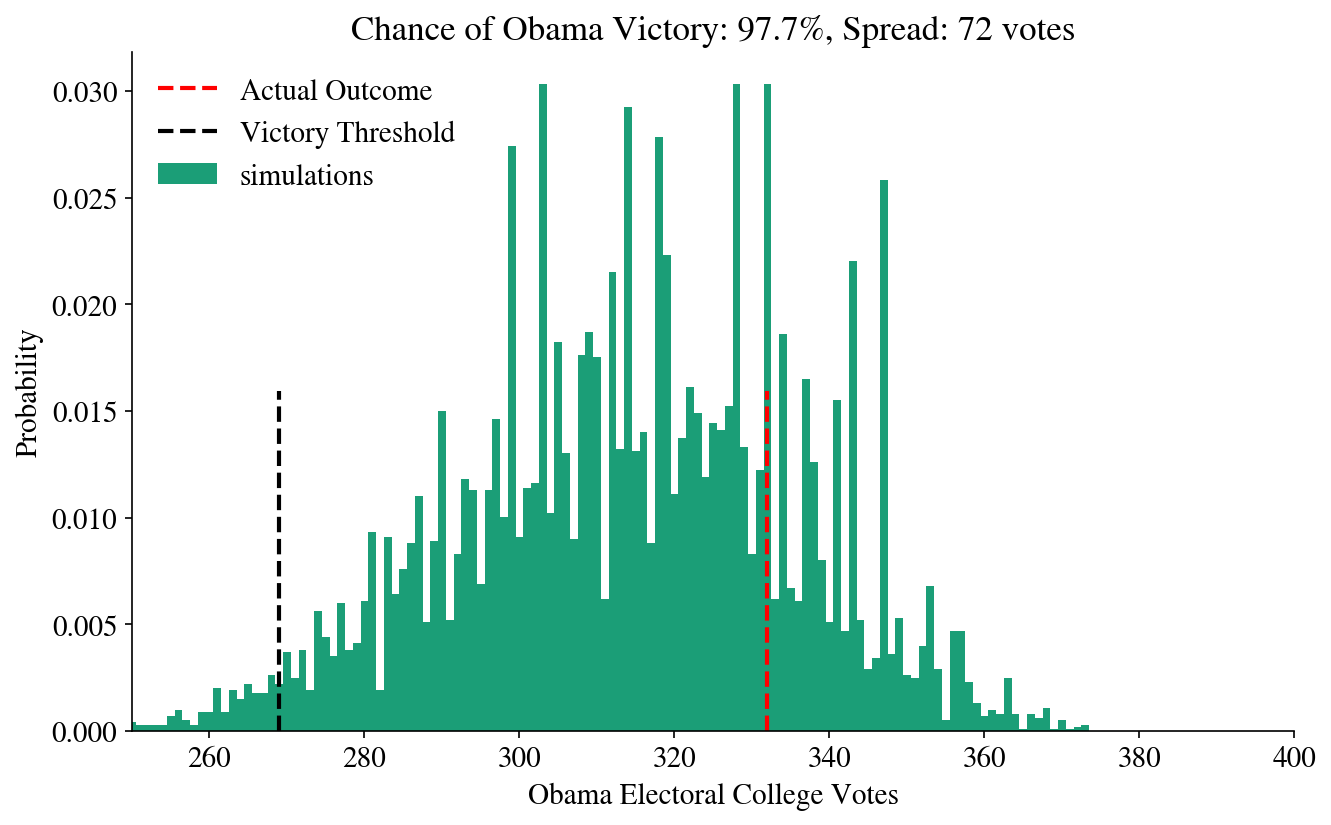

In [86]:
# Run 10,000 simulations with this model, and plot the results.
model = aggregated_poll_model(avg)
sims = simulate_election(model, 10000)
plot_simulation(sims)
plt.xlim(250, 400)

***Analysis***

#### The accuracy of this poll is somewhat greater than just taking the gallup poll. 

This is probably because
1. We're using as inputs polls that are trying to predict the election, so there is nothing "lost in translation", and
2. We are averaging many polls together, so `some of their biases are likely to offset each other`.

#### Issues

One problem is that we treated all polls as equal. Thus a bad poll with a small sample size is given equal footing as a good poll with a large one. 

Thus we are introducing bias both due to individual poll biases and individual poll sampling errors.

We also estimate the standard deviation by simply taking the spread of the percentages in the polls, without considering their `individual margins of error`. 

In the case of small sampling error per poll, this might be ok. However in states with some polls with `large margins of error` (Kansas, for eg), `this can lead to an overestimation of the standard deviation, pushing the predicted probability toward 0.5`. 

This, in turn, can hurt precision since it increases the chance that a state will flip sides in a simulation.

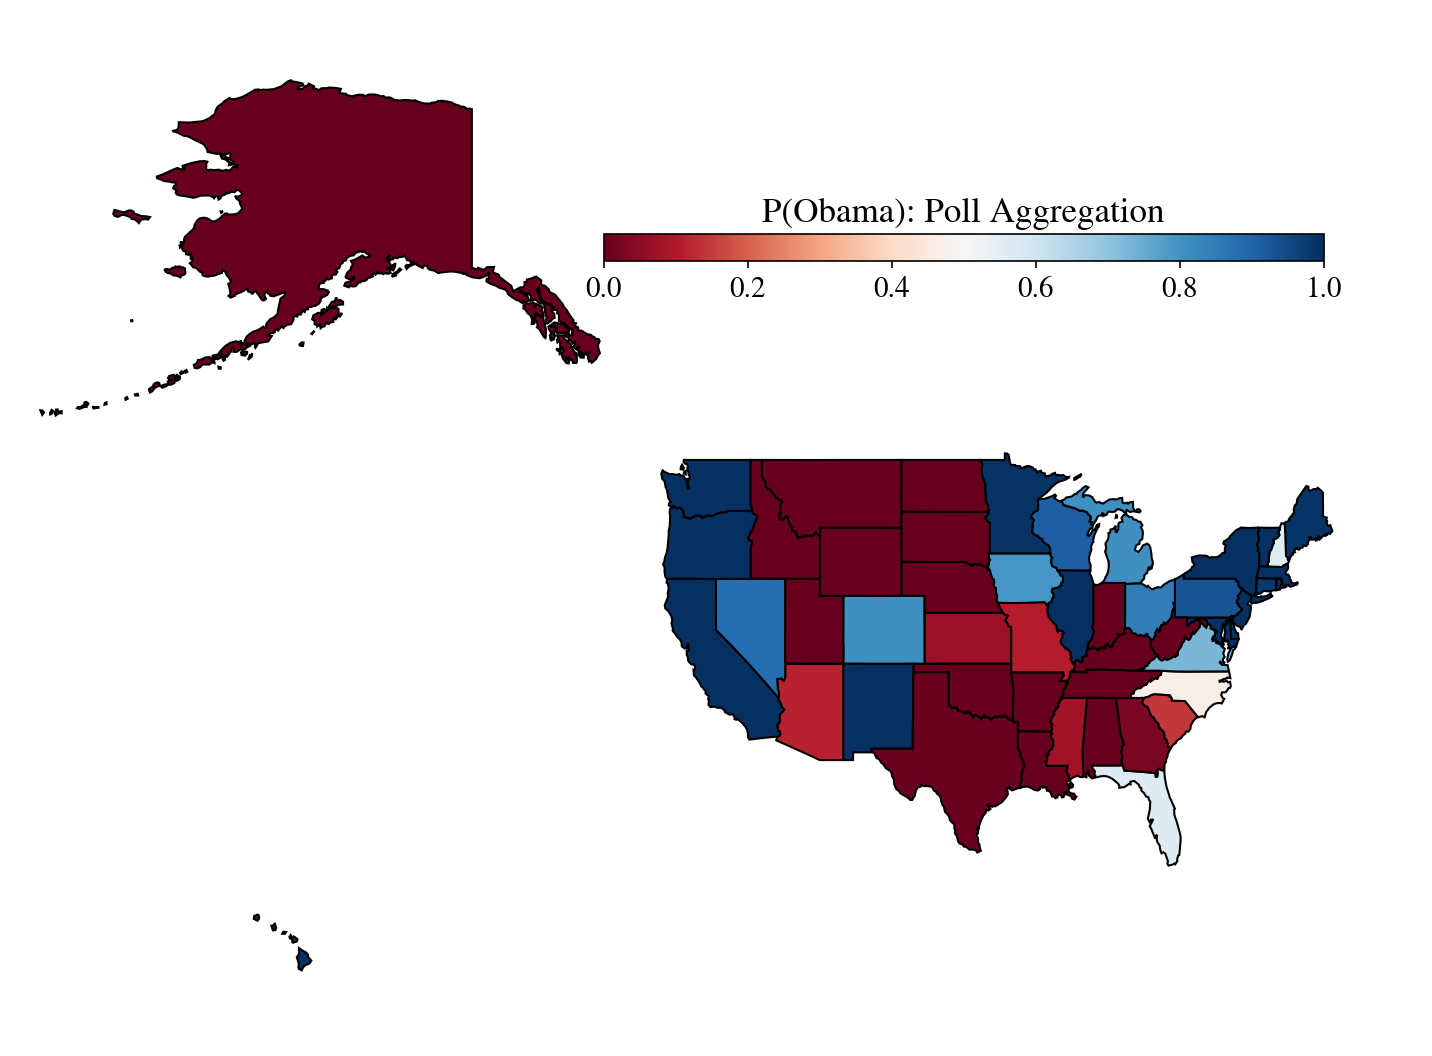

In [87]:
make_map(model.Obama, "P(Obama): Poll Aggregation")

---